# Nerds Viajantes - Generate Topics

## Import libraries

In [15]:
# Third party libraries
import pandas as pd
import re
import nltk
import numpy as np

"""
A list of stopwords can be found in the corpus module of nltk package. We are going to try to use the portuguese version. The download code is necessary only once.
"""
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# import nltk
# nltk.download('stopwords')


In [16]:
# Self package code
from repository import nerds_viajantes
from collect.clean_text import stemm_text

In [17]:
# Text preprocessing and modelling
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.model_selection import train_test_split
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel

In [18]:
# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='talk')
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim

In [19]:
# Warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [20]:
published = nerds_viajantes.read_published()

## Limpeza de posts

In [21]:
# Check document size to see if we should remove some of  them
# Looking at character length of documents will give an indication of too short documents.
published['n_characters'] = published['content'].str.len()
published.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1029.0,8422.824101,3860.734536,11.0,5049.0,10527.0,10784.0,15389.0
comment_count,1029.0,3.695821,8.599599,0.0,0.0,0.0,4.0,90.0
n_characters,1029.0,4108.211856,6533.186527,0.0,24.0,40.0,5888.0,48775.0


In [22]:
# Avalia posts menores que 20 caracteres para ver que tipo de posts são. Este codigo ja pode ser comentando porque apos avaliacao inicial eu percebi que filtrar os posts com mais de 42 caracteres seriam suficiente, o que eh feito abaixo. Sendo assim este codigo esta aqui apenas para documentacao.
# published.query("n_characters<20").sort_values('n_characters', ascending=False)

# Duvida? Sera que eu deveria fazer esta contagem de caracteres apos os posts terem tags html removidas?

# Ha muitos posts pequenos, que devem ser desconsiderados. Analisando estes eu percebi que os posts de papel de parede (calendario) estao entre os pequenos e fui aumentando o tamanho minimo de post ate todos serem removidos

# Exclude short documents
# 42 me pareceu ser o tamanho do maior post de calendario (papel de parede)
# todos menores foram removidos
published.query("n_characters>=42", inplace=True)
published.nsmallest(5, 'n_characters')

,id,date,content,title,name,modified,comment_count,n_characters
1011,14946,2017-12-21 21:07:38,Posts sobre a América Central. Veja todas as d...,,14946,2017-12-21 21:07:38,0,82
466,8896,2014-04-23 20:43:31,Nesta seção contamos como algumas fotos de via...,,8896,2017-12-21 21:07:38,0,134
340,8184,2014-03-04 12:53:29,Esta página reune as nossas recomendações!\r\n...,Recomendamos,recomendamos,2016-06-22 14:56:20,0,185
10,822,2012-03-28 08:35:46,Quer entrar em contato com a gente? Envie um e...,Contato,contato,2016-09-08 21:28:15,0,462
323,5828,2013-04-15 09:00:55,"<a href=""http://www.nerdsviajantes.com/wp-cont...",Pesquisa - Perfil dos Leitores do Blog,pesquisa-perfil-dos-leitores-do-blog,2013-10-30 08:57:11,2,816


## Enriquecimento

Algumas paginas especiais do blog sao tratados como posts e devem ser removidas pois nao fazem parte do conteudo que queremos tratar. Sao elas:

* Papel de parede: Sobraram alguns mesmo apos a remocao de textos pequenos: 
* Recomendamos: outros blogs os quais Recomendamos
* Contato: post com informações de contato dos editores do blog
* Quem somos: um pouco sobre os editores do blog, tambem irrelevante para levantamento de topicos
* Pesquisa de perfil de leitores do blog
* Posts publicados no início que agregam pouco valor ao blog (exemplo, post da India)
* Posts patrocinados. Analisar melhor mas a principio preferimos remover
* Posts temporais: posts que tiveram valor apenas na epoca. Um exemplo disso eh o post do convite de nossa exposicao de fotos de parques nacionais americanos, que fizemos em bar de belo horizonte

A Analisar:

* Posts com title vazio
* Posts de avaliacao de aplicativo: weather channel? Por enquanto deixar mas avaliar
* Posts indice: Vale a pena remover ou nao? Talvez seja algo a analisar.
* Lugares que não existem mais. O que fazer?
* Posts de roteiro: o que fazer? Patagonia? Islandia? A principio vou manter

**Ideia**: Colocar a lista de "name" a remover em um arquivo csv e carregar de la porque aqui pode ficar muito grande.

In [87]:
# Remover papel de parede
papel_parede = published['name'].str.startswith('papel-de-parede')

# Verificar quantos papeis de parede ainda existem
(unique, counts) = np.unique(papel_parede, return_counts=True)
frequencies = np.asarray((unique, counts)).T

# Verificamos que ainda haviam 60 papeis de parede mesmo apos remover os textos menores que 42
# frequencies

published = published[~papel_parede].reset_index(drop=True) 

# Ha o caso em que o "name" comeca com "papel-parede"
papel_parede = published['name'].str.startswith('papel-parede')
published = published[~papel_parede].reset_index(drop=True) 

In [122]:
names_remover = [
    'recomendamos', 'contato', 'pesquisa-perfil-dos-leitores-do-blog',
    'india-folha-dicas-de-sobrevivencia',
    'google-oferece-wi-fi-gratis-nos-bares-do-brasil',
    'na-midia-nerd-na-puc-tv',
    'parceria-mondial-assistance', # comercial
    'estude-idiomas-e-fuja-do-silencio', # post patrocinado
    'quem-somos',
    'tripadvisor-top-25-hoteis', # Publicado em 2012 (temporal) e ainda irrelevante para levantamento de topicos, nao eh conteudo nosso
    'infraero-internet-gratuita-nos-aeroportos', # temporal, 2012
    'convite-exposicao-fotografica-parques-nacionais-americanos', # temporal, 2012
    'exposicao-fotografica-parques-nacionais-americanos', # temporal, 2012
    'trip-advisor-vistas-espetaculares-da-cama-do-hotel', # comercial e temporal
    'blogs-viajens', # referencia para outros blogs de viagens
    'tres-anos-de-nerds-viajantes', # temporal
    'relato-assalto-a-mao-armada-em-genipabu', # apoio a conhecidos
    'rbbv-rede-brasileira-de-blogueiros-de-viagem', # comercial
    'evento-workshop-argentina', # comercial e temporal
    'blog-action-day-the-power-of-we', # comercial
    'peru-um-pais-a-ser-explorado', # comercial, post patrocinado
    'belo-horizonte-feliz-115-anos', # post temporal
    'encontro-rede-brasileira-de-blogueiros-de-viagem', # temporal
    'acompanhe-todas-as-nossas-atualizacoes-pelo-facebook', # comercial
    'blogosfera-viajante-secreto', # temporal
    'um-ano-de-nerds-viajantes', # temporal
    'sorteio-album-de-fotos-o-segredo-do-vitorio', # comercial
    'sorteio-guia-essencial-gramado-e-canela', # comercial
    'sorteio-guia-miami-romero-britto', # comercial
    'sorteio-de-cape-town-a-muscat-uma-aventura-pela-africa', # comercial
    'sorteio-porta-retrato-lata-turista-chic', # comercial
    'visitando-aeroporto-viracopos', # temporal e comercial
    'concurso-assista-a-final-da-uefa-champions-league-em-wembley', # comercial
    'intrip-reserve-exeriencias-viagem', # outros blogs
    'nerd-na-globo-bom-dia-minas', # comercial
    'voando-com-a-azul-linhas-aereas', # comercial
    'estamos-de-volta', # post pessoal e sem conteudo a definir topico
    'adventure-bloggers-jalapao-eu-vou', # comercial e temporal
    'retrospectiva-2013', # temporal
    'dois-anos-de-nerds-viajantes', # temporal
    'concurso-cultural-viajar-e', # temporal e comercial
    'serra-cipo-fotos-pos-casamento', # pessoal
    'livro-guia-essencial-de-curitiba', # comercial
    'emirates-airlines-conectando-os-amantes-do-futebol', # comercial
    'na-midia-nerds-na-tv-horizonte', # comercial e temporal
    'dicas-capa-mala-trippy', # comercial
    'na-midia-programa-caleidoscopio-argentina', # temporal e comercial
    'desconto-no-seguro-de-viagem-outubro2015', # temporal e comercial
    'mondial-assistance-seguro-viagem-desconto', # comercial
    'quatro-anos-de-nerds-viajantes', # temporal
    'cinco-anos-de-nerds-viajantes', # temporal
    'fidelidade-livelo-acumular-pontos' # comercial
 ]
published = published[~published['name'].isin(names_remover)]
# published.nsmallest(5, 'n_characters')

In [123]:
# Trabalho manual de varrer todos os posts para ver um a um qual poderia ser removido. O criterio, obviamente, nao foi ler os posts mas avaliar pelo proprio name.
# 0 a 59 esta ok (tirar papel de parede)
# published.iloc[360:][['date', 'title', 'name', 'n_characters']]
#published.loc[272]['name']
#published.shape

## Limpeza de conteudo textual

In [124]:
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

In [125]:
def remove_stopwords(text):
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in pt_stopwords]
    return " ".join(tokens_without_sw)

In [126]:
"""
Remover caption de imagens
"""
def remover_caption(text):
    clean = re.compile('\[.*caption.*\]')
    return re.sub(clean, '', text)

In [127]:
def stemm_text(text):
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return " ".join(stemmed_tokens)

In [128]:
def remove_punctuations(text):
    tokeniser = RegexpTokenizer(r'[A-Za-z]{3,}')
    tokens = tokeniser.tokenize(text)
    return tokens

In [129]:
pt_stopwords = stopwords.words('portuguese')
stemmer = nltk.stem.RSLPStemmer()

def preprocess_text(text):
    no_html = remove_html_tags(text)
    no_sw = remove_stopwords(no_html)
    no_caption = remover_caption(no_sw)
    stemmed = stemm_text(no_caption)
    no_punct = remove_punctuations(stemmed)
    preprocessed = no_punct
    return preprocessed

In [130]:
# Generate documents
documents = published['content'].apply(preprocess_text)

In [131]:
# Creates a dictionary, mapping words to ids
id2word = Dictionary(documents)
# id2word.token2id

In [132]:
# We can see word: word id pairs in this output. For instance, word id = 5 represents ‘mango’. Using the dictionary, we can transform the preprocessed documents into numerical representation:
corpus = [id2word.doc2bow(document) for document in documents]
print(corpus[0])
# Here, we see (word id, word count) pairs for each unique word in the first document.

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2), (30, 1), (31, 1), (32, 2), (33, 1), (34, 2), (35, 1), (36, 2), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 5), (45, 1), (46, 1), (47, 2), (48, 2), (49, 1), (50, 2), (51, 1), (52, 2), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 4), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 2), (85, 1), (86, 1), (87, 1), (88, 13), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 2), (107, 2), (108, 1), (109, 1), (110, 1)

In [133]:
# Build a simple model
num_topics = 5
lda = LdaModel(corpus=corpus, id2word=id2word, 
               num_topics=num_topics, passes=20, 
               random_state=0)
for i in range(num_topics):
    print(f"********** Topic {i+1} **********")
    print(lda.print_topic(i, topn=5), '\n')

********** Topic 1 **********
0.012*"lag" + 0.010*"cidad" + 0.010*"com" + 0.008*"dia" + 0.008*"visit" 

********** Topic 2 **********
0.039*"fot" + 0.016*"fotograf" + 0.015*"jalap" + 0.009*"revel" + 0.008*"expos" 

********** Topic 3 **********
0.018*"viag" + 0.011*"viaj" + 0.009*"hotel" + 0.009*"com" + 0.008*"parqu" 

********** Topic 4 **********
0.015*"passei" + 0.012*"restaurant" + 0.011*"por" + 0.010*"com" + 0.009*"glaci" 

********** Topic 5 **********
0.010*"fot" + 0.009*"igrej" + 0.008*"cas" + 0.008*"alt" + 0.007*"min" 



In [134]:
# Usually, many consider partitioning dataset in unsupervised modelling has little value as there is no target to check against. However, I think it would be good to set aside a handful of unseen test documents to sense check the model later.
X_train, X_test = train_test_split(documents, test_size=5, random_state=1)
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (372,)
Test size: (5,)


In [135]:
# Let’s transform the training documents into numerical representation.

# Process documents
#documents = [preprocess_text(document, stop_words) for document in X_train]
print('First document: ', documents[0], '\n')

# Create word id mappings
id2word = Dictionary(documents)
id2word.filter_extremes(no_below=5)
print('Number of unique words: ' + str(len(id2word.token2id.keys())), '\n')

# Transform documents to numbers
corpus = [id2word.doc2bow(document) for document in documents]
print('First document: ', corpus[0])

First document:  ['prim', 'dia', 'santiag', 'tent', 'visit', 'mus', 'art', 'colombi', 'cheg', 'local', 'depar', 'mes', 'pesso', 'jog', 'cart', 'tarot', 'com', 'prim', 'dia', 'santiag', 'ach', 'situ', 'inusit', 'depois', 'vim', 'sup', 'comum', 'rua', 'cidad', 'procur', 'bilhet', 'mus', 'depar', 'plac', 'avis', 'mus', 'fech', 'reform', 'muit', 'trist', 'consult', 'sit', 'mus', 'perceb', 'fech', 'dia', 'dezembr', 'final', 'previs', 'dat', 'cert', 'reabr', 'ness', 'per', 'espa', 'mus', 'ampli', 'est', 'mudan', 'permitir', 'aument', 'espa', 'expos', 'mostr', 'blic', 'quas', 'dobr', 'cole', 'patrimon', 'mus', 'cole', 'mus', 'agrup', 'cult', 'mesoam', 'xic', 'guatemal', 'hond', 'salv', 'part', 'nicar', 'interm', 'col', 'equ', 'carib', 'mar', 'carib', 'antill', 'ama', 'selv', 'amaz', 'and', 'centr', 'peru', 'bol', 'and', 'sul', 'chil', 'argentin', 'vej', 'posicion', 'mus', 'atrav', 'map', 'seguint', 'par', 'quis', 'program', 'visit', 'segu', 'algum', 'inform', 'essenc', 'hor', 'ter', 'doming',

In [136]:
def compute_coherence(num_topics):
    """Compute coherence score given a number of topics."""
    lda = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics,
        passes=20, random_state=0)
    cm = CoherenceModel(model=lda, texts=documents, dictionary=id2word, coherence='c_v')
    return cm.get_coherence()

In [137]:
# Código demora muito para executar
coherence = pd.DataFrame(index=range(2,15), columns=['coherence'])
for i in coherence.index:
    c = compute_coherence(i)
    coherence.loc[i, 'coherence'] = c
coherence

# maiores valores: 
# 7	0.502767
# 8	0.496939
# 13	0.493946

,coherence
2,0.320047
3,0.416805
4,0.414232
5,0.397279
6,0.480778
7,0.502767
8,0.496939
9,0.422443
10,0.449828
11,0.476561


In [138]:
# Lets run an LDA model with 13 topics now
num_topics = 13
lda = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=20,
    random_state=0)
for i in range(num_topics):
    print(f"********** Topic {i+1} **********")
    print(lda.print_topic(i), '\n')

********** Topic 1 **********
0.031*"prai" + 0.024*"ros" + 0.012*"sant" + 0.011*"cont" + 0.011*"mar" + 0.010*"mund" + 0.010*"pous" + 0.010*"pesc" + 0.009*"catarin" + 0.009*"viag" 

********** Topic 2 **********
0.033*"restaurant" + 0.017*"viaj" + 0.013*"hotel" + 0.013*"curitib" + 0.011*"curitiblog" + 0.010*"blogu" + 0.010*"viag" + 0.009*"trip" + 0.009*"mochil" + 0.008*"caf" 

********** Topic 3 **********
0.015*"parqu" + 0.015*"dia" + 0.014*"lag" + 0.013*"passei" + 0.010*"visit" + 0.010*"algum" + 0.010*"cheg" + 0.010*"caminh" + 0.009*"faz" + 0.009*"cidad" 

********** Topic 4 **********
0.028*"cidad" + 0.023*"visit" + 0.022*"hotel" + 0.019*"sit" + 0.019*"http" + 0.018*"www" + 0.017*"reserv" + 0.017*"local" + 0.017*"procur" + 0.015*"agor" 

********** Topic 5 **********
0.017*"expos" + 0.016*"tir" + 0.015*"fotograf" + 0.013*"abert" + 0.012*"iso" + 0.012*"algum" + 0.011*"hor" + 0.011*"fic" + 0.011*"configur" + 0.010*"faz" 

********** Topic 6 **********
0.047*"por" + 0.023*"camp" + 0.020

In [147]:
content = published

In [148]:
# Let’s add the topic probabilities to each training document.
def add_probabilities(document):
    """Add probabilities for topics for a document."""
    # Preprocess text
    # tokens = preprocess_text(document, stop_words)
    tokens = preprocess_text(document)
    corpus = id2word.doc2bow(tokens)

    # Predict probabilities
    predictions = lda.get_document_topics(corpus, minimum_probability=0.0)
    topics = [topic for topic, probability in predictions]
    return [prediction[1] for prediction in predictions]

# Add probabilities
pd.options.display.max_colwidth = 50
train = pd.DataFrame(content)
columns = ['topic' + str(i+1) for i in range(num_topics)]
train[columns] = train['content'].apply(add_probabilities).to_list()
train.head()

,id,date,content,title,name,modified,comment_count,n_characters,topic1,topic2,...,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13
0,11,2012-01-21 12:00:01,"No nosso primeiro dia em <a href=""www.nerdsvia...",Santiago - Museu de Arte Pré-Colombiana Fechad...,santiago-museu-de-arte-pre-colombiana-fechado-...,2013-04-19 16:41:23,1,3420,0.000513,0.000513,...,0.529249,0.205612,0.000513,0.000513,0.000513,0.000513,0.000513,0.000513,0.000513,0.000513
1,60,2012-02-24 12:16:22,"Sexta-feira em <a href=""http://www.nerdsviajan...",Santiago - Restaurante Aquí Está Coco,santiago-restaurante-aqui-esta-coco,2013-04-19 18:13:46,5,5775,0.000846,0.561508,...,0.333118,0.040075,0.000846,0.000846,0.000846,0.000846,0.000846,0.000846,0.057688,0.000846
2,111,2012-02-15 17:41:51,"O Palacio de la Moneda, ou somente La Moneda é...",Santiago - Palacio de la Moneda,santiago-palacio-de-la-moneda,2012-10-13 09:12:49,5,4852,0.000658,0.000658,...,0.992110,0.000658,0.000658,0.000658,0.000658,0.000658,0.000658,0.000658,0.000658,0.000658
3,134,2012-02-16 11:27:03,"Inauguramos hoje a seção <a href=""http://www.n...",Revelando a Foto - Frutillar,revelando-a-foto-frutillar,2012-12-26 22:38:13,3,2353,0.000836,0.000836,...,0.000836,0.708679,0.000836,0.000836,0.000836,0.000836,0.000836,0.000836,0.282123,0.000836
4,167,2012-02-23 22:02:45,"O <a href=""http://www.nerdsviajantes.com/categ...",Revelando a Foto - Monument Valley,revelando-a-foto-monument-valley,2013-06-08 08:46:32,2,2047,0.000818,0.000818,...,0.000818,0.539410,0.000818,0.000818,0.000818,0.000818,0.000818,0.000818,0.000818,0.182583


In [149]:
# Now, let’s organise the probabilities. We will create a few new columns:
train = train.assign(top1=np.nan, prob1=np.nan, top2=np.nan, 
                     prob2=np.nan, top3=np.nan, prob3=np.nan,
                     top4=np.nan, prob4=np.nan, top5=np.nan, 
                     prob5=np.nan, top6=np.nan, prob6=np.nan,
                     top7=np.nan, prob7=np.nan, top8=np.nan, prob8=np.nan,
                     top9=np.nan, prob9=np.nan, top10=np.nan, prob10=np.nan,
                     top11=np.nan, prob11=np.nan, top12=np.nan, prob12=np.nan,
                     top13=np.nan, prob13=np.nan
                     )
top_cols = ['top' + str(i) for i in range(1, 14)]
prob_cols = ['prob' + str(i) for i in range(1, 14)]
for record in train.index:
    top = train.loc[record, 'topic1':'topic13'].astype(float).nlargest(13)
    train.loc[record, top_cols] = top.index
    train.loc[record, prob_cols] = top.values
train.drop(columns='content').head()

,id,date,title,name,modified,comment_count,n_characters,topic1,topic2,topic3,...,top9,prob9,top10,prob10,top11,prob11,top12,prob12,top13,prob13
0,11,2012-01-21 12:00:01,Santiago - Museu de Arte Pré-Colombiana Fechad...,santiago-museu-de-arte-pre-colombiana-fechado-...,2013-04-19 16:41:23,1,3420,0.000513,0.000513,0.260010,...,topic11,0.000513,topic1,0.000513,topic2,0.000513,topic6,0.000513,topic9,0.000513
1,60,2012-02-24 12:16:22,Santiago - Restaurante Aquí Está Coco,santiago-restaurante-aqui-esta-coco,2013-04-19 18:13:46,5,5775,0.000846,0.561508,0.000846,...,topic10,0.000846,topic1,0.000846,topic13,0.000846,topic8,0.000846,topic9,0.000846
2,111,2012-02-15 17:41:51,Santiago - Palacio de la Moneda,santiago-palacio-de-la-moneda,2012-10-13 09:12:49,5,4852,0.000658,0.000658,0.000658,...,topic6,0.000658,topic7,0.000658,topic1,0.000658,topic9,0.000658,topic2,0.000658
3,134,2012-02-16 11:27:03,Revelando a Foto - Frutillar,revelando-a-foto-frutillar,2012-12-26 22:38:13,3,2353,0.000836,0.000836,0.000836,...,topic11,0.000836,topic9,0.000836,topic1,0.000836,topic2,0.000836,topic8,0.000836
4,167,2012-02-23 22:02:45,Revelando a Foto - Monument Valley,revelando-a-foto-monument-valley,2013-06-08 08:46:32,2,2047,0.000818,0.000818,0.269822,...,topic8,0.000818,topic6,0.000818,topic2,0.000818,topic9,0.000818,topic1,0.000818


Text(0.5, 1.0, 'Probability of dominant topic colour coded by topics')

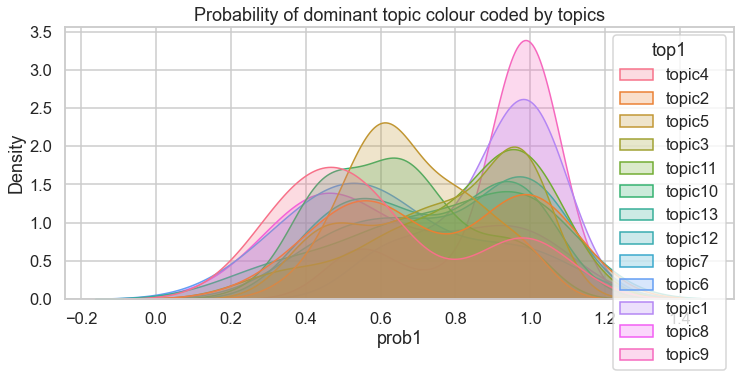

In [150]:
# Now, let’s visualise the probability distribution for the most dominant topic. Ideally, we prefer if most probabilities are centered around higher value.
plt.figure(figsize=(12,5))
sns.kdeplot(data=train, x='prob1', hue='top1', shade=True, common_norm=False)
plt.title('Probability of dominant topic colour coded by topics')

In [151]:
# Great to see that majority of the values are close to 1. Let’s inspect the summary stats for the probability values:
train[prob_cols].describe()
# Median probability for the most dominant topic is 0.9466. That’s awesome!

,prob1,prob2,prob3,prob4,prob5,prob6,prob7,prob8,prob9,prob10,prob11,prob12,prob13
count,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000,377.000000
mean,0.723255,0.175000,0.067302,0.021937,0.004798,0.001502,0.000947,0.000876,0.000876,0.000876,0.000876,0.000876,0.000876
std,0.220895,0.138467,0.080932,0.042965,0.016001,0.005617,0.001534,0.000705,0.000705,0.000705,0.000705,0.000705,0.000705
min,0.260799,0.000285,0.000207,0.000095,0.000095,0.000095,0.000095,0.000095,0.000095,0.000095,0.000095,0.000095,0.000095
25%,0.536580,0.001452,0.000747,0.000601,0.000546,0.000531,0.000531,0.000531,0.000531,0.000531,0.000531,0.000531,0.000531
50%,0.709286,0.192132,0.012153,0.000916,0.000777,0.000726,0.000719,0.000719,0.000719,0.000719,0.000719,0.000719,0.000719
75%,0.982581,0.287535,0.132022,0.019442,0.001183,0.001026,0.001012,0.000999,0.000999,0.000999,0.000999,0.000999,0.000999
max,0.996581,0.491648,0.294138,0.213654,0.112865,0.070487,0.027334,0.008547,0.008547,0.008547,0.008547,0.008547,0.008547
